# 1. GC состав
По FASTQ (http://en.wikipedia.org/wiki/FASTQ_format) файлу определить средний GC-состав ридов и его распределение. Распределение GC состава есть график, на котором по оси x отложен GC состав, а по оси y -- его частота, то есть количество ридов с соответствующим составом.

Функция isGoodRead принимает на вход количество AT в риде (cntAT), количество GC(cntGC) и количество неизвестных или некачественных ридов (cntN), а так же количество бакетов(bucket_cnt), которое определяет точность с которой хочется понять GC состав. Если возможно понять GC состав из данного рида, то функция возвращает True, если же качество рида недостаточно, то возвращается false.   

In [2]:
def isGoodRead(cntAT, cntGC, cntN, bucket_cnt):
    if (cntAT + cntGC > bucket_cnt):
        return True
    return False

Функция getGCDistribution принимает на вход путь до fastq файла(file_name) и количество бакетов(bucket_cnt) и возвращает список длины (bucket_cnt), где i-ое значениче списака "--- это количество ридов с GC составом в промежутке $[\frac{i \cdot 100}{bucket\_cnt}, \frac{(i + 1) \cdot 100}{bucket\_cnt})$

При этом учитываются только качественные нуклеатиды и только те риды, для которых функция isGoodRead вернула, что рид является хорошим. 

In [3]:
from Bio import SeqIO

def getGCDistribution(file_name, bucket_cnt):
    ans = [0]*(bucket_cnt)
    cnt = 0
    for rec in SeqIO.parse(file_name, "fastq"):
        if cnt % 100000 == 0:
            print(cnt)
        cnt += 1
        
        cntAT = 0
        cntGC = 0
        cntN = 0
        reclen = len(rec.seq)
        for i in range(reclen):
            #max quality = 93,  0(!) --- lowest quality, 93(~) --- highest
            #when N quality often 33(B) 
            quality_trash_hold = 33
            if (rec.letter_annotations["phred_quality"][i] > quality_trash_hold):
                if (rec.seq[i] == 'A' or rec.seq[i] == 'T'):
                    cntAT += 1
                elif (rec.seq[i] == 'G' or rec.seq[i] == 'C'):
                    cntGC += 1
                elif (rec.seq[i] == 'N'):
                    cntN += 1
                else:
                    assert True, rec.seq[i] + " not equal A, T, G, C, N"
            else:
                cntN += 1
        
        if isGoodRead(cntAT, cntGC, cntN, bucket_cnt):
            if cntAT != 0:
                ans[cntGC*bucket_cnt//(cntGC + cntAT)] += 1
    return ans
    

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline  

def showGCDistribution(file_name, bcnt):
    delta = 100//bcnt
    xs = [(i + (i + delta))/2 for i in range(0, 100, delta)]
    ys = getGCDistribution(file_name, bcnt)
    
    print(xs)
    print(ys)
    
    plt.plot(xs, ys, 'r+')
    plt.axis([0, 100, 0, max(ys) + 5])
    plt.xlabel('%GC')
    plt.ylabel('Number of reads')
    plt.title(file_name)
    plt.show()

0
[2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 87.5, 92.5, 97.5]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]


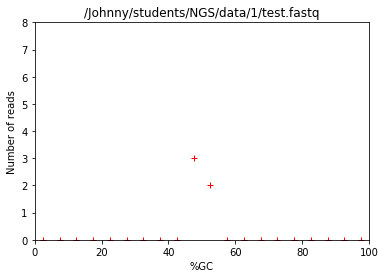

In [6]:
showGCDistribution("/Johnny/students/NGS/data/1/test.fastq", 20)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

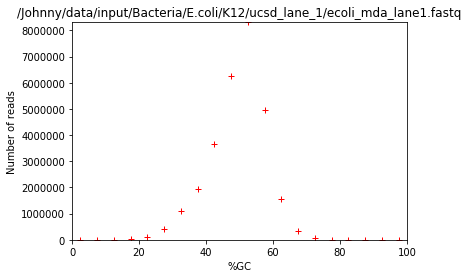

In [7]:
showGCDistribution("/Johnny/data/input/Bacteria/E.coli/K12/ucsd_lane_1/ecoli_mda_lane1.fastq", 20)

# 2. Распределение качества
По FASTQ файлу построить распределение вероятности ошибки в зависимости от позиции нуклеотида.

Функция getQualityByPosition принимает на вход file_name в fastq формате и возвращает для каждой позиции список качеств. 

In [56]:
import numpy as np

def getQualityByPosition(file_name):
    posqv = []
    cnt = 0
    for rec in SeqIO.parse(file_name, "fastq"):
        if cnt % 100000 == 0:
            print(cnt)
        cnt += 1
        reclen = len(rec.seq)
        for i in range(reclen):
            if i >= len(posqv):
                posqv.append([])
            posqv[i].append(rec.letter_annotations["phred_quality"][i])
    return posqv

In [65]:
def showQualityByPosition(file_name):
    dataset = getQualityByPosition(file_name)
    fig = plt.figure(1, figsize=(30,30))
    ax = fig.add_subplot(111)
    ax.boxplot(dataset)
    plt.xlabel('position')
    plt.ylabel('quality')
    plt.title(file_name)
    plt.show()


0


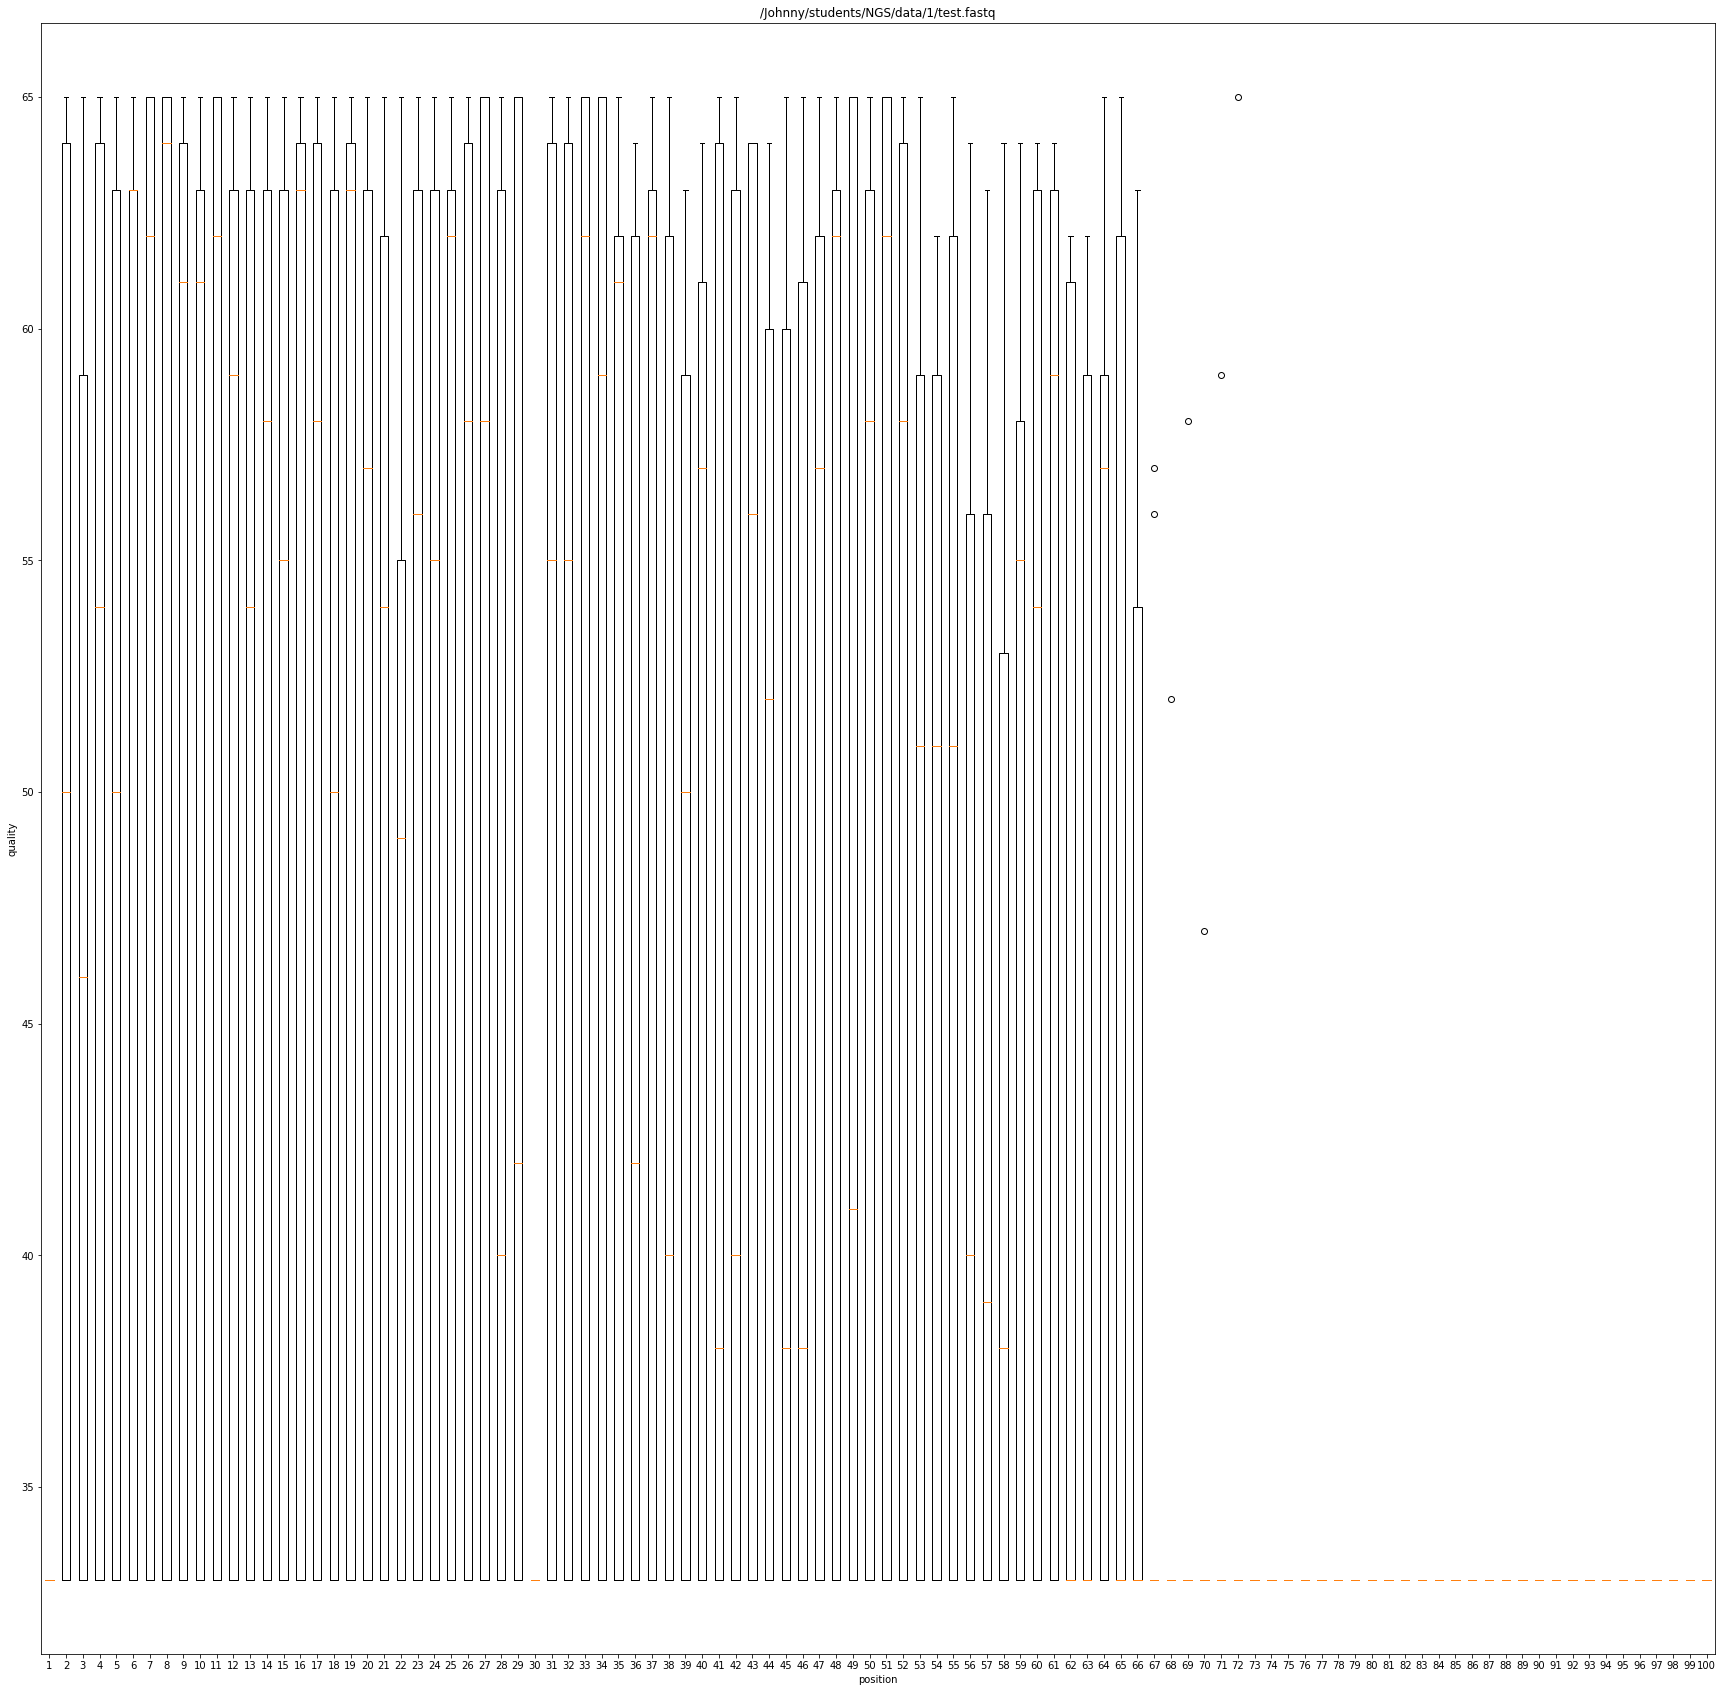

In [66]:
showQualityByPosition("/Johnny/students/NGS/data/1/test.fastq")

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

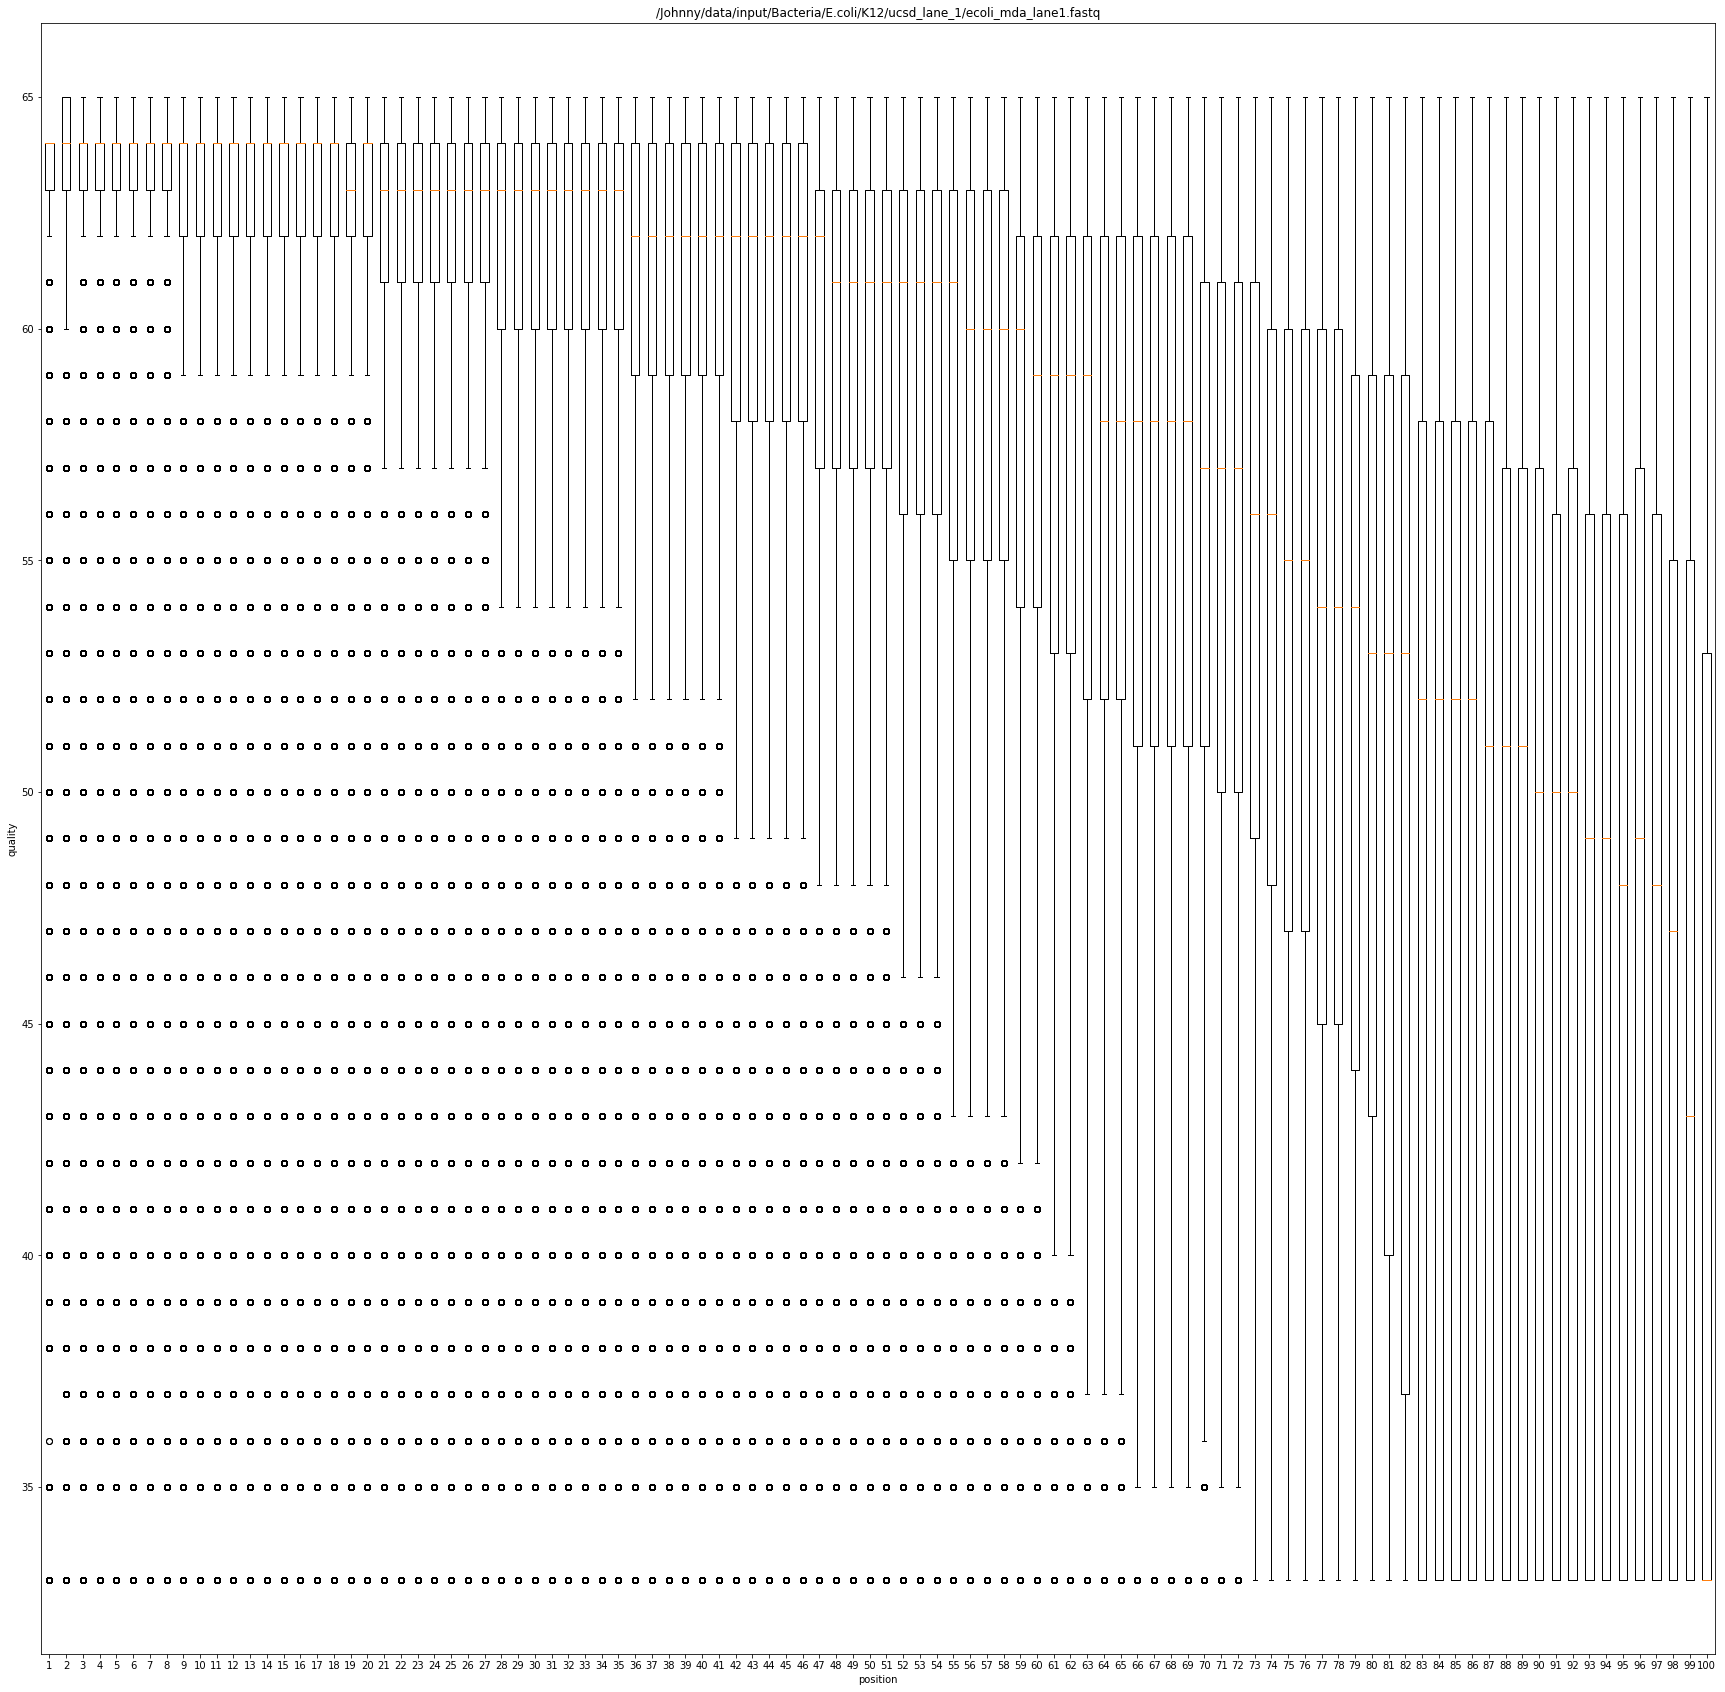

In [67]:
showQualityByPosition("/Johnny/data/input/Bacteria/E.coli/K12/ucsd_lane_1/ecoli_mda_lane1.fastq")

# 3. Проверка результатов
Запустите на входных данных программу fastqc и сверьте полученные результаты с вашими. 

In [16]:
! /Molly/chernikova/soft/FastQC/fastqc /Johnny/data/input/Bacteria/E.coli/K12/ucsd_lane_1/ecoli_mda_lane1.fastq -o ./

Started analysis of ecoli_mda_lane1.fastq
Too many tiles (>1000) so giving up trying to do per-tile qualities since we're probably parsing the file wrongly
Approx 5% complete for ecoli_mda_lane1.fastq
Approx 10% complete for ecoli_mda_lane1.fastq
Approx 15% complete for ecoli_mda_lane1.fastq
Approx 20% complete for ecoli_mda_lane1.fastq
Approx 25% complete for ecoli_mda_lane1.fastq
Approx 30% complete for ecoli_mda_lane1.fastq
Approx 35% complete for ecoli_mda_lane1.fastq
Approx 40% complete for ecoli_mda_lane1.fastq
Approx 45% complete for ecoli_mda_lane1.fastq
Approx 50% complete for ecoli_mda_lane1.fastq
Approx 55% complete for ecoli_mda_lane1.fastq
Approx 60% complete for ecoli_mda_lane1.fastq
Approx 65% complete for ecoli_mda_lane1.fastq
Approx 70% complete for ecoli_mda_lane1.fastq
Approx 75% complete for ecoli_mda_lane1.fastq
Approx 80% complete for ecoli_mda_lane1.fastq
Approx 85% complete for ecoli_mda_lane1.fastq
Approx 90% complete for ecoli_mda_lane1.fastq
Approx 95% comple

In [17]:
! unzip ecoli_mda_lane1_fastqc.zip

Archive:  ecoli_mda_lane1_fastqc.zip
   creating: ecoli_mda_lane1_fastqc/
   creating: ecoli_mda_lane1_fastqc/Icons/
   creating: ecoli_mda_lane1_fastqc/Images/
  inflating: ecoli_mda_lane1_fastqc/Icons/fastqc_icon.png  
  inflating: ecoli_mda_lane1_fastqc/Icons/warning.png  
  inflating: ecoli_mda_lane1_fastqc/Icons/error.png  
  inflating: ecoli_mda_lane1_fastqc/Icons/tick.png  
  inflating: ecoli_mda_lane1_fastqc/summary.txt  
  inflating: ecoli_mda_lane1_fastqc/Images/per_base_quality.png  
  inflating: ecoli_mda_lane1_fastqc/Images/per_sequence_quality.png  
  inflating: ecoli_mda_lane1_fastqc/Images/per_base_sequence_content.png  
  inflating: ecoli_mda_lane1_fastqc/Images/per_sequence_gc_content.png  
  inflating: ecoli_mda_lane1_fastqc/Images/per_base_n_content.png  
  inflating: ecoli_mda_lane1_fastqc/Images/sequence_length_distribution.png  
  inflating: ecoli_mda_lane1_fastqc/Images/duplication_levels.png  
  inflating: ecoli_mda_lane1_fastqc/Images/adapter_content.png  
  i

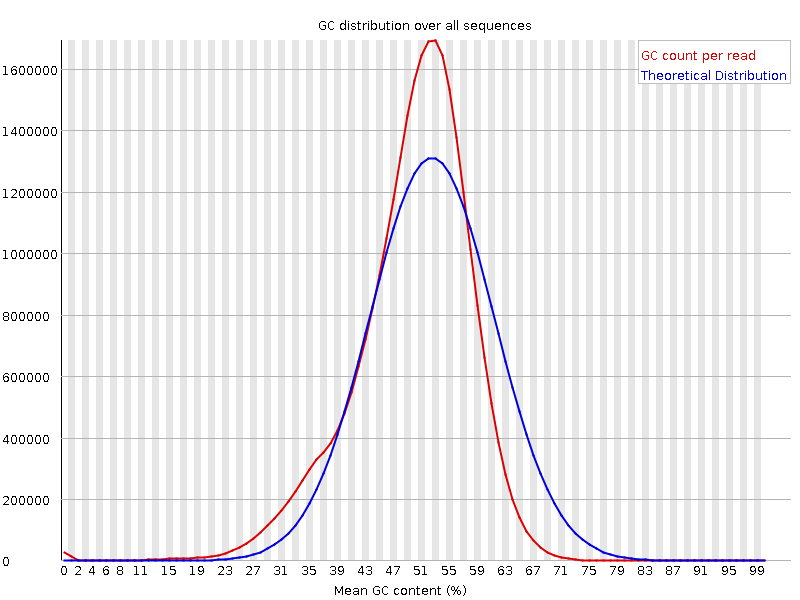

In [18]:
from IPython.display import Image
Image("ecoli_mda_lane1_fastqc/Images/per_sequence_gc_content.png")

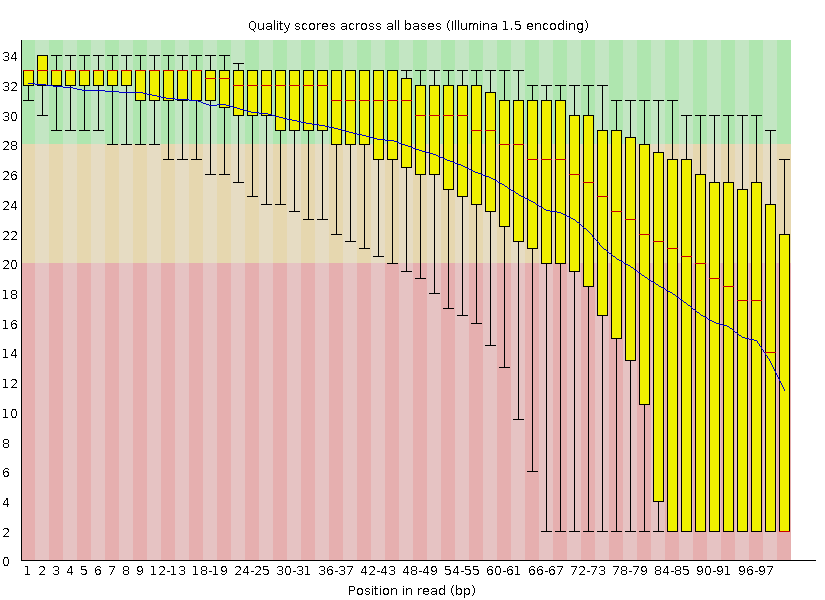

In [20]:
from IPython.display import Image
Image("ecoli_mda_lane1_fastqc/Images/per_base_quality.png")

# 4.* Спектры k-меров 
Иногда для анализа входных ридов строят спектры k-меров (нуклеотидных последовательностей длины k). Для относительно небольшого k (от 2 до 8) считают сколько раз каждый возможный k-мер встречается в ридах. Результат можно изобразить в виде графика.

Функция genAllSeq принимает на вход длину и возвращает список всех последовательностей из букв A, T, G, C заданной длины. 

In [36]:
def genAllSeq(length):
    letters = "ATGC"
    seqs = []
    for i in range(4**length):
        x = i
        curs = ""
        for j in range(length):
            curs += letters[x%4]
            x = x//4
        seqs.append(curs)
    return seqs

In [ ]:
Функция getKmerSpectrum принимает на вход путь до файла в fastq формате и длину k-меров и
возвращает dict где каждой последовательности без N длины k соответсвует количество таких
последовательностей в ридах. 

In [49]:
def getKmerSpectrum(file_name, length):
    res = dict()
    cnt = 0
    for rec in SeqIO.parse(file_name, "fastq"):
        if cnt % 1000 == 0:
            print(cnt)
        cnt += 1
        
        reclen = len(rec.seq)
        for i in range(reclen - length):
            subseq = rec.seq[i:i+length]
            if "N" not in subseq:
                if subseq not in res:
                    res[subseq] = 0
                res[subseq] += 1
            
    return res

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline  

def showKmerSpectrum(file_name, length):
    xs = genAllSeq(length)
    kmerSpect = getKmerSpectrum(file_name, length)
    ys = []
    for x in xs:
        if x in kmerSpect:
            ys.append(kmerSpect[x])
        else:
            ys.append(0)
    
    plt.figure(figsize=(30,30))
    plt.plot(xs, ys, 'bo')
    plt.xlabel('seq')
    plt.ylabel('Number of seq in reads')
    plt.title(file_name)
    plt.show()

0


/home/chernikova_o/anaconda3/lib/python3.6/site-packages/Bio/Seq.py:152: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


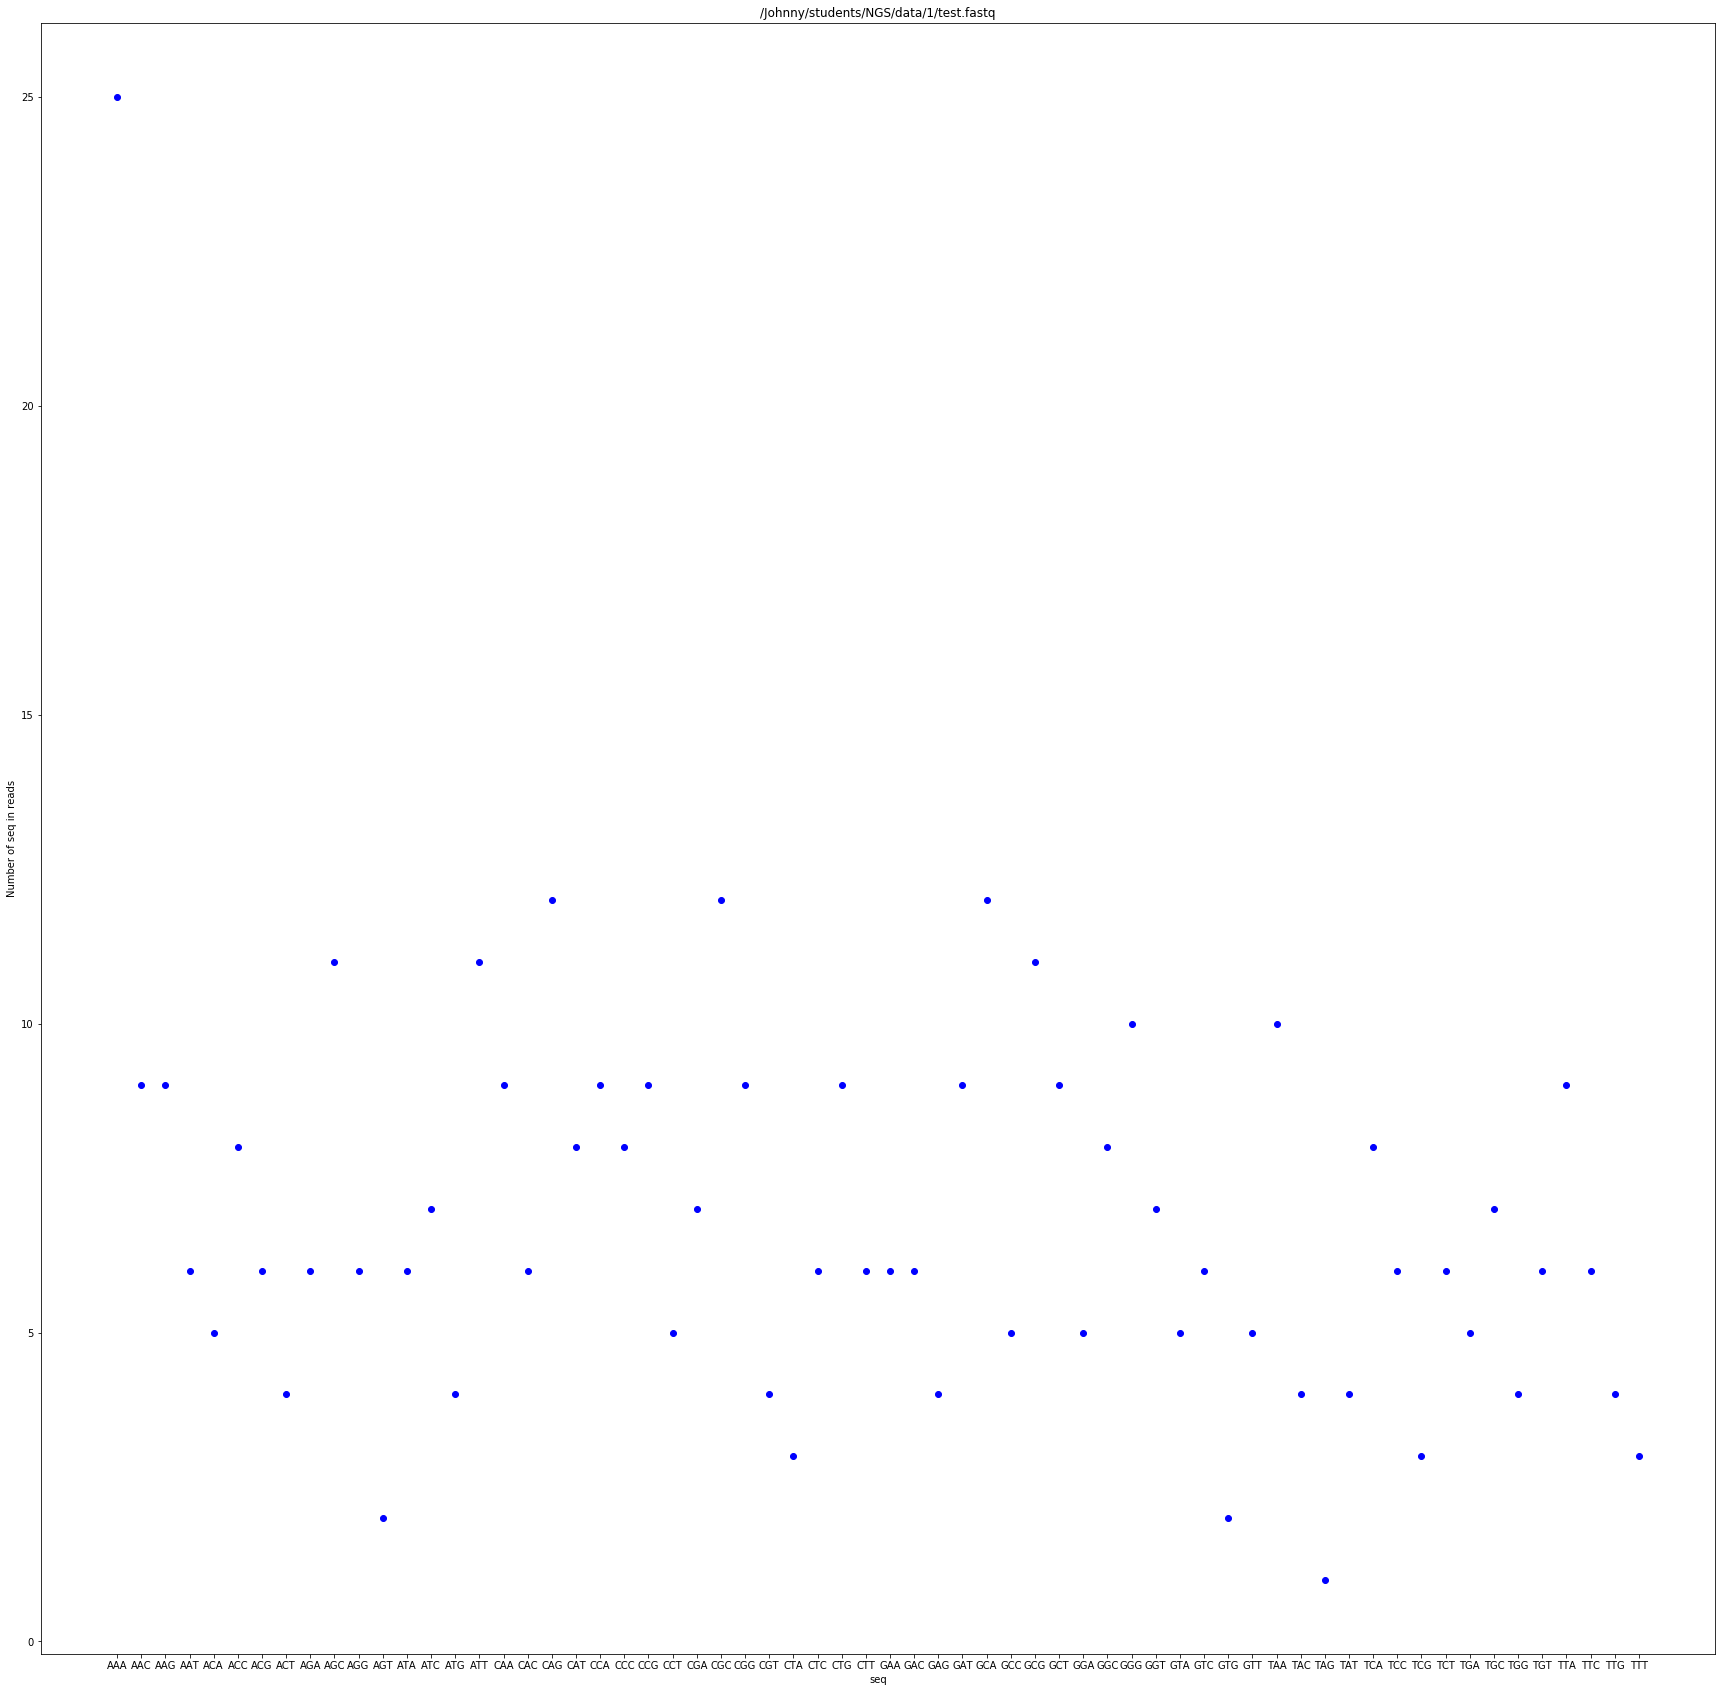

In [51]:
showKmerSpectrum("/Johnny/students/NGS/data/1/test.fastq", 3)

In [52]:
showKmerSpectrum("/Johnny/data/input/Bacteria/E.coli/K12/ucsd_lane_1/ecoli_mda_lane1.fastq", 3)

0


/home/chernikova_o/anaconda3/lib/python3.6/site-packages/Bio/Seq.py:152: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000


KeyboardInterrupt: 